In [671]:
import pandas as pd
import numpy as np

In [672]:
data = pd.read_csv('data/credit/application_record.csv')

record = pd.read_csv('data/credit/credit_record.csv')

In [673]:
print(f"Shape: {data.shape}")
print(data.columns)
print(f"Shape: {record.shape}")
print(record.columns)

Shape: (438557, 18)
Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')
Shape: (1048575, 3)
Index(['ID', 'MONTHS_BALANCE', 'STATUS'], dtype='object')


Kaggle Notebook: https://www.kaggle.com/code/rikdifos/credit-card-approval-prediction-using-ml/notebook

## Feature Engineering

**Target variable**

- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month 
- X: No loan for the month


TARGET VARIABLE: User at risk (1/0). 1 if overdue for more than 60 days (label 2,3,4,5)

In [674]:
record.ID.nunique()

45985

In [735]:
record_d = pd.get_dummies(data=record,columns=['STATUS'], prefix='', prefix_sep='').groupby('ID')[sorted(record['STATUS'].unique().tolist())].sum()
record_d['bad_customer'] = np.where((record_d['1'] + record_d['2'] + record_d['3'] + record_d['4'] >= 2) | (record_d['5'] > 0), 1, 0)

In [736]:
record_d.bad_customer.value_counts()

bad_customer
0    43391
1     2594
Name: count, dtype: int64

In [594]:
def is_worsening(status_list):
    for i in range(len(status_list) - 1):
        # Check if the status is worsening
        if status_list[i] < status_list[i + 1]:
            return True
    return False

record_past_6_monhts = record.groupby('ID').head(6)
record_past_6_monhts['STATUS'] = record_past_6_monhts['STATUS'].str.replace('C','-1')
record_past_6_monhts['STATUS'] = record_past_6_monhts['STATUS'].str.replace('X','-2')

# Group by Customer_ID and apply the function
worsening_customers = record_past_6_monhts.groupby('ID')['STATUS'].apply(list).apply(is_worsening)

worsening_customers_df = pd.DataFrame(worsening_customers).reset_index()
worsening_customers_df['STATUS'] = np.where(worsening_customers_df['STATUS'] == True, 1, 0)
worsening_customers_df.columns = ['ID','worsening']

C:\Users\giorg\AppData\Local\Temp\ipykernel_37044\3048201566.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record_past_6_monhts['STATUS'] = record_past_6_monhts['STATUS'].str.replace('C','-1')
C:\Users\giorg\AppData\Local\Temp\ipykernel_37044\3048201566.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record_past_6_monhts['STATUS'] = record_past_6_monhts['STATUS'].str.replace('X','-2')


In [595]:
worsening_customers_df.worsening.value_counts()

worsening
0    34124
1    11861
Name: count, dtype: int64

In [598]:
new_record = pd.merge(record_d, worsening_customers_df, on='ID', how='left')[['ID','bad_customer','worsening']]
new_record['target'] = np.where(new_record['bad_customer'] == 1, 1, np.where(new_record['worsening'] == 1, 1, 0))
new_record = new_record.drop(['bad_customer','worsening'], axis=1)
new_record.target.value_counts()

target
0    33188
1    12797
Name: count, dtype: int64

In [753]:
new_data = pd.merge(data, record_d.reset_index()[['ID','bad_customer']], how='inner', on='ID')
new_data.rename(columns={'bad_customer':'target'}, inplace=True)
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,1
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,1
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,1
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,1


Bad Customer: A customer is classified as bad if they have:
- More than 2 instances of a status between 1 and 4 (indicating being past due between 30 to 149 days) over their entire history, or
- Any instance of a status of 5 (indicating overdue or bad debts for more than 150 days), or
- A recent trend toward worsening status (e.g., moving from status 0 to 1 or higher in the last 6 months).

Good Customer: A customer is considered good if none of the above conditions are met.

In [555]:
## Filer out those with only "X" statuses

record = record.groupby('ID').filter(lambda x: not all(x['STATUS'] == 'X'))

In [558]:
def define_target(group):
    # Count instances of statuses 1-4
    late_payments = group['STATUS'].isin(['1', '2', '3', '4']).sum()
    # Check for any instance of status '5'
    extreme_late = ('5' in group['STATUS'].values)
    # Check for recent trend towards worse status in the last 6 months
    # Assuming 'MONTHS_BALANCE' is sorted in ascending order (earliest to latest)
    recent_trend = group.sort_values('MONTHS_BALANCE', ascending=False)['STATUS'].head(6).isin(['1', '2', '3', '4']).any()
    
    bad_customer = 1 if late_payments > 2 or extreme_late or recent_trend else 0
    # If any of the bad criteria are met, return 1 for all rows in the group, else 0
    return pd.Series(bad_customer, index=group.index)

# Apply the function to each group and assign the result to a new column
record['target'] = record.groupby('ID').apply(define_target)

TypeError: incompatible index of inserted column with frame index

In [501]:
record_25 = record[record.STATUS.isin(['2','3','4','5'])]
record_25 = record_25.groupby('ID').agg({'STATUS':'count'})
record_25.columns = ['months_overdue']
record_25

,months_overdue
ID,
5002126,5
5002255,1
5002283,1
5002303,2
5002380,1
...,...
5149834,11
5149838,11
5150049,1


<Axes: >

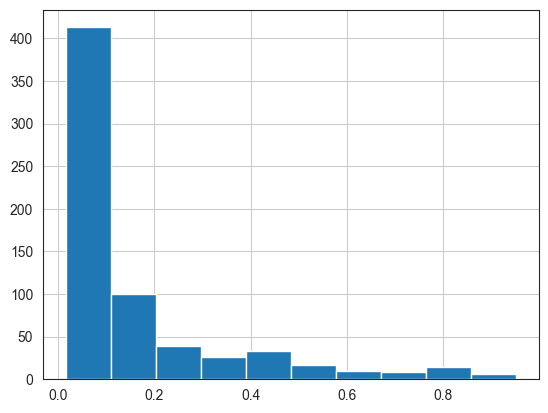

In [513]:
record_tot = record.groupby('ID').agg({'STATUS':'count'})
record_tot.columns = ['months_tot']


record_merge = pd.merge(record_25, record_tot, on='ID', how='right')
record_merge['pct_overdue'] = record_merge['months_overdue']/record_merge['months_tot']
record_merge['risky'] = np.where(record_merge['pct_overdue'] > 0.05, 1, 0)
record_merge.pct_overdue.hist()


In [514]:
record_merge.risky.value_counts()

risky
0    45566
1      419
Name: count, dtype: int64

In [534]:
record.isnull().sum()

ID                     0
MONTHS_BALANCE         0
STATUS                 0
target            910901
dtype: int64

In [517]:
new_data = pd.merge(data, record[['ID','target']], on='ID', how='left')
new_data.risky.fillna(0, inplace=True)
new_data.risky.value_counts()

risky
0.0    438164
1.0       393
Name: count, dtype: int64

In [430]:
# # Create variable "begin_month" --> age of the account
# begin_month = pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))
# begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'}) 

# new_data = pd.merge(data,begin_month,how="left",on="ID") #merge to record data


# record['dep_value'] = np.where(record['STATUS'].isin(['2','3','4','5']), 'Yes', None)

# # Flag customers who have been late 60+ days at least once
# cpunt = record.groupby('ID').count()
# cpunt['dep_value'] = np.where(cpunt['dep_value'] >0, 'Yes','No')
# cpunt = cpunt[['dep_value']]

# new_data = pd.merge(new_data, cpunt, how='inner', on='ID')

# new_data['target'] = new_data['dep_value']
# new_data['target'] = np.where(new_data['target']=='Yes', 1, 0)

# new_data.target.value_counts()


**Alternative Approach**

In [431]:
grouped = record.groupby('ID')['STATUS'].value_counts()
grouped

ID       STATUS
5001711  0          3
         X          1
5001712  0         10
         C          9
5001713  X         22
                   ..
5150483  X         18
5150484  0         12
         C          1
5150485  0          2
5150487  C         30
Name: count, Length: 94143, dtype: int64

In [432]:
record.groupby('STATUS').count()

,ID,MONTHS_BALANCE
STATUS,,
0,383120,383120
1,11090,11090
2,868,868
3,320,320
4,223,223
5,1693,1693
C,442031,442031
X,209230,209230


<Axes: xlabel='STATUS'>

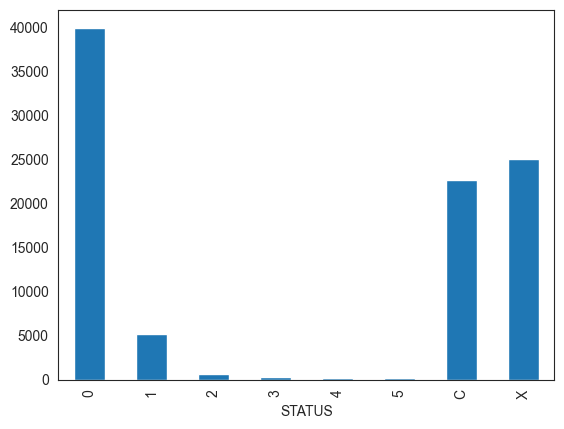

In [433]:
number_of_customer_for_each_status = grouped.groupby('STATUS').count()
number_of_customer_for_each_status.plot(kind='bar')

In [563]:
credit_grouped = pd.get_dummies(data=record,columns=['STATUS'], prefix='', prefix_sep='').groupby('ID')[sorted(record['STATUS'].unique().tolist())].sum()

credit_grouped=credit_grouped.rename(columns=
                      {'0':'pastdue_1_29',
                       '1':'pastdue_30_59',
                       '2':'pastdue_60_89',
                       '3':'pastdue_90_119',
                       '4':'pastdue_120_149',
                       '5':'pastdue_over_150',
                       'C':'paid_off',
                       'X':'no_loan',
                      })


credit_grouped['number_of_months'] = record.groupby('ID')['MONTHS_BALANCE'].count()  # Number of months per customer in the record
credit_grouped['over_90'] = credit_grouped[['pastdue_90_119', 'pastdue_120_149'	,'pastdue_over_150']].sum(axis=1)  # Number of months the customer has been over 90 days past due
credit_grouped['less_90'] = credit_grouped[['pastdue_1_29','pastdue_30_59',	'pastdue_60_89']].sum(axis=1) # Number of months the customer has been less than 90 days past due

overall_pastdue = ['pastdue_1_29','pastdue_30_59', 'pastdue_60_89',	'pastdue_90_119','pastdue_120_149',	'pastdue_over_150']
credit_grouped['overall_pastdue'] = credit_grouped[overall_pastdue].sum(axis=1)  # Total number of months the customer has been past due


## Difference between number of months the customer has been paid off and the number of months the customer has been past due
credit_grouped['paid_pastdue_diff'] = credit_grouped['paid_off'] - credit_grouped['overall_pastdue']

credit_grouped

,pastdue_1_29,pastdue_30_59,pastdue_60_89,pastdue_90_119,pastdue_120_149,pastdue_over_150,paid_off,no_loan,number_of_months,over_90,less_90,overall_pastdue,paid_pastdue_diff
ID,,,,,,,,,,,,,
5001711,3,0,0,0,0,0,0,1,4,0,3,3,-3
5001712,10,0,0,0,0,0,9,0,19,0,10,10,-1
5001713,0,0,0,0,0,0,0,22,22,0,0,0,0
5001714,0,0,0,0,0,0,0,15,15,0,0,0,0
5001715,0,0,0,0,0,0,0,60,60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,12,0,0,0,0,0,6,0,18,0,12,12,-6
5150483,0,0,0,0,0,0,0,18,18,0,0,0,0
5150484,12,0,0,0,0,0,1,0,13,0,12,12,-11


In [435]:
target=[]

for index,row in credit_grouped.iterrows() :
  
  if row['paid_pastdue_diff'] >=3 or (row ['no_loan']==row['number_of_months']):
    target.append(1)
  
  elif row['paid_pastdue_diff'] >-2 and row['paid_pastdue_diff'] <3 and (row['less_90'] >=row['over_90']):
    target.append(1)

  else:
    target.append(0)

credit_grouped['target'] = target
credit_grouped['target'].value_counts()

target
1    24083
0    21902
Name: count, dtype: int64

In [436]:
new_data = pd.merge(data, credit_grouped.reset_index()[['ID','target']], how='inner', on='ID')
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,1,0,0,0,Managers,2.0,0
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.0,0
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,Sales staff,2.0,0


#### Binary Variables

**Gender**

In [754]:
print(new_data['CODE_GENDER'].value_counts())

new_data['CODE_GENDER'] = np.where(new_data['CODE_GENDER']=='M', 1, 0)

CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64


In [755]:
new_data['CODE_GENDER'].isnull().sum()

0

**Own a car**

In [756]:
print(new_data['FLAG_OWN_CAR'].value_counts())

new_data['FLAG_OWN_CAR'] = np.where(new_data['FLAG_OWN_CAR']=='Y', 1, 0)

FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64


**Own Realty**

In [757]:
print(new_data['FLAG_OWN_REALTY'].value_counts())

new_data['FLAG_OWN_REALTY'] = np.where(new_data['FLAG_OWN_REALTY']=='Y', 1, 0)

FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64


**Own Phone**

In [758]:
print(new_data['FLAG_PHONE'].value_counts())

FLAG_PHONE
0    25709
1    10748
Name: count, dtype: int64


**Own Work Phone**

In [759]:
new_data['FLAG_WORK_PHONE'] = np.where(new_data['FLAG_WORK_PHONE']=='Y', 1, 0)

**Own Email**

In [760]:
new_data['FLAG_EMAIL'].value_counts()

FLAG_EMAIL
0    33186
1     3271
Name: count, dtype: int64

#### Numerical Variables

**Children Count**

In [761]:
new_data['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64

In [746]:
new_data['CNT_CHILDREN'] = np.where(new_data['CNT_CHILDREN']>=2, '2+ childrens',
                                    np.where(new_data['CNT_CHILDREN']==1, '1', '0'))

print(new_data['CNT_CHILDREN'].value_counts())
new_data = pd.get_dummies(new_data, columns=['CNT_CHILDREN'])

CNT_CHILDREN
0               25201
1                7492
2+ childrens     3764
Name: count, dtype: int64


**Income**

In [762]:
new_data['AMT_INCOME_TOTAL'].describe()

count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

In [763]:
new_data['AMT_INCOME_TOTAL'] = new_data['AMT_INCOME_TOTAL']#/10000

In [751]:
new_data['AMT_INCOME_TOTAL'] = pd.qcut(new_data['AMT_INCOME_TOTAL'], q = 3, labels = ["low","medium", "high"])
new_data['AMT_INCOME_TOTAL'].value_counts()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [394]:
new_data = pd.get_dummies(new_data, columns=['AMT_INCOME_TOTAL'])

**Age**

In [764]:
new_data['AGE'] = new_data['DAYS_BIRTH']/-365

#new_data['AGE'] = pd.qcut(new_data['AGE'], q = 3, labels = ["low","medium", "high"])

In [765]:
new_data = new_data.drop(columns=['DAYS_BIRTH'])

In [398]:
new_data = pd.get_dummies(new_data, columns=['AGE'])

**Working Years**

In [766]:
new_data['YEARS_EMPLOYED'] = - new_data['DAYS_EMPLOYED'] / 365	
new_data['YEARS_EMPLOYED'] = np.where(new_data['YEARS_EMPLOYED']<0, np.nan,new_data['YEARS_EMPLOYED'])


#new_data['YEARS_EMPLOYED'] = pd.qcut(new_data['YEARS_EMPLOYED'], q = 5, labels = ["lowest","low","medium","high","highest"])
#new_data['YEARS_EMPLOYED'].value_counts()

In [767]:
new_data['YEARS_EMPLOYED'] = new_data['YEARS_EMPLOYED'].fillna(0)

In [401]:
new_data = pd.get_dummies(new_data, columns=['YEARS_EMPLOYED'])

In [768]:
new_data = new_data.drop(columns=['DAYS_EMPLOYED'])

**Family Size**

In [769]:
new_data['CNT_FAM_MEMBERS'].value_counts()

CNT_FAM_MEMBERS
2.0     19463
1.0      6987
3.0      6421
4.0      3106
5.0       397
6.0        58
7.0        19
15.0        3
9.0         2
20.0        1
Name: count, dtype: int64

In [404]:
new_data['CNT_FAM_MEMBERS'] = np.where(new_data['CNT_FAM_MEMBERS']>=3, '3+ members', 
                                       np.where(new_data['CNT_FAM_MEMBERS']==2, '2',
                                                np.where(new_data['CNT_FAM_MEMBERS']==1, '1', '0')))

In [405]:
new_data = pd.get_dummies(new_data, columns=['CNT_FAM_MEMBERS'])

#### Categorical Variables

**Occupation**

In [770]:
# Define the occupation categories
laborwk_categories = ['Cleaning staff', 'Cooking staff', 'Drivers', 'Laborers', 'Low-skill Laborers', 'Security staff', 'Waiters/barmen staff']
officewk_categories = ['Accountants', 'Core staff', 'HR staff', 'Medicine staff', 'Private service staff', 'Realty agents', 'Sales staff', 'Secretaries']
hightecwk_categories = ['Managers', 'High skill tech staff', 'IT staff']

new_data['OCCUPATION_TYPE'] = np.where(new_data['OCCUPATION_TYPE'].isin(laborwk_categories), 'labor', 
                                       np.where(new_data['OCCUPATION_TYPE'].isin(officewk_categories), 'office',
                                                np.where(new_data['OCCUPATION_TYPE'].isin(hightecwk_categories), 'hightec', 'other')))

In [771]:
new_data.OCCUPATION_TYPE.value_counts()

OCCUPATION_TYPE
other      11323
labor      10496
office     10183
hightec     4455
Name: count, dtype: int64

In [772]:
new_data = pd.get_dummies(new_data, columns=['OCCUPATION_TYPE'])

**Income**

In [773]:
new_data['NAME_INCOME_TYPE'] = np.where(new_data['NAME_INCOME_TYPE'].isin(['Pensioner', 'Student']), 'State servant' ,new_data['NAME_INCOME_TYPE'])

In [774]:
new_data.NAME_INCOME_TYPE.value_counts()

NAME_INCOME_TYPE
Working                 18819
State servant            9148
Commercial associate     8490
Name: count, dtype: int64

In [775]:
## Create dummy variables - one hot encoding
new_data = pd.get_dummies(new_data, columns=['NAME_INCOME_TYPE'])

**House Type**

In [776]:
new_data['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: count, dtype: int64

In [777]:
new_data = pd.get_dummies(new_data, columns=['NAME_HOUSING_TYPE'])

**Acedemic level**

In [778]:
new_data['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: count, dtype: int64

In [779]:
new_data['NAME_EDUCATION_TYPE'] = np.where(new_data['NAME_EDUCATION_TYPE']=='Academic degree', 'Higher education', new_data['NAME_EDUCATION_TYPE'])

# dummies
new_data = pd.get_dummies(new_data, columns=['NAME_EDUCATION_TYPE'])

**Marriage Condition**

In [780]:
new_data['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: count, dtype: int64

In [781]:
new_data = pd.get_dummies(new_data, columns=['NAME_FAMILY_STATUS'])

## Models

In [782]:
new_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'target', 'AGE', 'YEARS_EMPLOYED',
       'OCCUPATION_TYPE_hightec', 'OCCUPATION_TYPE_labor',
       'OCCUPATION_TYPE_office', 'OCCUPATION_TYPE_other',
       'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
 

In [783]:
X = new_data.drop(['ID','target'], axis=1)
y = new_data['target']

In [784]:
from sklearn.model_selection import train_test_split

In [785]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    stratify=y, test_size=0.3,
                                                    random_state = 42)

In [786]:
y_train.value_counts()

target
0    24043
1     1476
Name: count, dtype: int64

In [787]:
##SMOTE oversampling
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [788]:
y_res.value_counts()

target
0    24043
1    24043
Name: count, dtype: int64

In [789]:
y_train.value_counts()

target
0    24043
1     1476
Name: count, dtype: int64

In [790]:
numerical_columns = ['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED', 'CNT_CHILDREN']

In [791]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25519 entries, 24711 to 6473
Data columns (total 34 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   CODE_GENDER                                        25519 non-null  int32  
 1   FLAG_OWN_CAR                                       25519 non-null  int32  
 2   FLAG_OWN_REALTY                                    25519 non-null  int32  
 3   CNT_CHILDREN                                       25519 non-null  int64  
 4   AMT_INCOME_TOTAL                                   25519 non-null  float64
 5   FLAG_MOBIL                                         25519 non-null  int64  
 6   FLAG_WORK_PHONE                                    25519 non-null  int32  
 7   FLAG_PHONE                                         25519 non-null  int64  
 8   FLAG_EMAIL                                         25519 non-null  int64  
 9   CNT_FAM_

In [792]:
X_train, y_train = X_res, y_res

In [793]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

**Logistic Regression**

In [794]:
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns


model = LogisticRegression()


model.fit(X_train, y_train)

X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
y_predict = model.predict(X_test)

## METRICS
# Accuracy
log_accuracy = accuracy_score(y_test, y_predict)

# Precision
log_precision = precision_score(y_test, y_predict)

# Recall
log_recall = recall_score(y_test, y_predict)

# AUC
log_auc = roc_auc_score(y_test, y_predict)

pd.DataFrame(confusion_matrix(y_test,y_predict))

c:\Users\giorg\MIT\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,0,1
0,10280,26
1,620,12


In [795]:
## Metrics dataframe
log_metrics = pd.DataFrame({'Logistic Regression': [log_accuracy, log_precision, log_recall, log_auc]}, columns = ['Logistic Regression'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
log_metrics

,Logistic Regression
Accuracy,0.940940
Precision,0.315789
Recall,0.018987
AUC,0.508232


**CART**

In [796]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)


X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
y_predict = model.predict(X_test)


## METRICS
# Accuracy
cart_accuracy = accuracy_score(y_test, y_predict)

# Precision
cart_precision = precision_score(y_test, y_predict)

# Recall
cart_recall = recall_score(y_test, y_predict)

# AUC
cart_auc = roc_auc_score(y_test, y_predict)

pd.DataFrame(confusion_matrix(y_test,y_predict))

,0,1
0,7142,3164
1,447,185


In [797]:
cart_metrics = pd.DataFrame({'Decision Tree': [cart_accuracy, cart_precision, cart_recall, cart_auc]}, columns = ['Decision Tree'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
cart_metrics

,Decision Tree
Accuracy,0.669867
Precision,0.055240
Recall,0.292722
AUC,0.492858


**Random Forest**

In [798]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)


X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
y_predict = model.predict(X_test)

## METRICS
# Accuracy
rf_accuracy = accuracy_score(y_test, y_predict)

# Precision
rf_precision = precision_score(y_test, y_predict)

# Recall
rf_recall = recall_score(y_test, y_predict)

# AUC
rf_auc = roc_auc_score(y_test, y_predict)

pd.DataFrame(confusion_matrix(y_test,y_predict))

,0,1
0,9493,813
1,580,52


In [799]:
rf_metrics = pd.DataFrame({'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_auc]}, columns = ['Random Forest'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
rf_metrics  

,Random Forest
Accuracy,0.872646
Precision,0.060116
Recall,0.082278
AUC,0.501696


**LightGBM**

In [800]:
from lightgbm import LGBMClassifier


model = LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)


# X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
y_predict = model.predict(X_test)

## METRICS
# Accuracy
lgm_accuracy = accuracy_score(y_test, y_predict)

# Precision
lgm_precision = precision_score(y_test, y_predict)

# Recall
lgm_recall = recall_score(y_test, y_predict)

# AUC
lgm_auc = roc_auc_score(y_test, y_predict)

pd.DataFrame(confusion_matrix(y_test,y_predict))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24043, number of negative: 24043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 48086, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,0,1
0,8930,1376
1,527,105


In [801]:
lgm_metrics = pd.DataFrame({'LightGBM': [lgm_accuracy, lgm_precision, lgm_recall, lgm_auc]}, columns = ['LightGBM'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
lgm_metrics

,LightGBM
Accuracy,0.826019
Precision,0.070898
Recall,0.166139
AUC,0.516312


**XGBoost**

In [802]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train, y_train)


# X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
y_predict = model.predict(X_test)

## METRICS
# Accuracy
xgb_accuracy = accuracy_score(y_test, y_predict)
# Precision
xgb_precision = precision_score(y_test, y_predict)
# Recall
xgb_recall = recall_score(y_test, y_predict)
# AUC
xgb_auc = roc_auc_score(y_test, y_predict)

pd.DataFrame(confusion_matrix(y_test,y_predict))

,0,1
0,6483,3823
1,390,242


In [803]:
xgb_metrics = pd.DataFrame({'XGBoost': [xgb_accuracy, xgb_precision, xgb_recall, xgb_auc]}, columns = ['XGBoost'], index=['Accuracy', 'Precision', 'Recall', 'AUC'])
xgb_metrics

,XGBoost
Accuracy,0.614829
Precision,0.059533
Recall,0.382911
AUC,0.505981


**Summary**

In [804]:
metrics = pd.concat([log_metrics, cart_metrics, rf_metrics, lgm_metrics, xgb_metrics], axis=1)
metrics['Best Model'] = metrics.idxmax(axis=1)
metrics

,Logistic Regression,Decision Tree,Random Forest,LightGBM,XGBoost,Best Model
Accuracy,0.940940,0.669867,0.872646,0.826019,0.614829,Logistic Regression
Precision,0.315789,0.055240,0.060116,0.070898,0.059533,Logistic Regression
Recall,0.018987,0.292722,0.082278,0.166139,0.382911,XGBoost
AUC,0.508232,0.492858,0.501696,0.516312,0.505981,LightGBM
